## working with MNIST  dataset 

In [2]:
# import necessary lib
import numpy as np
import os 

np.random.seed(42)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

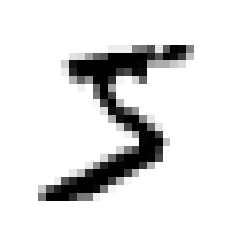

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [7]:
y[0]

'5'

In [8]:
# the label is a string . we have to convert into int
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
              interpolation='nearest')
    plt.axis("off")
    

In [10]:
#Extra
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # for empty grid
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    
    # reshape the array so it's gonna organized as grid containing 28x28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    big_picture = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    
    plt.imshow(big_picture, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
    

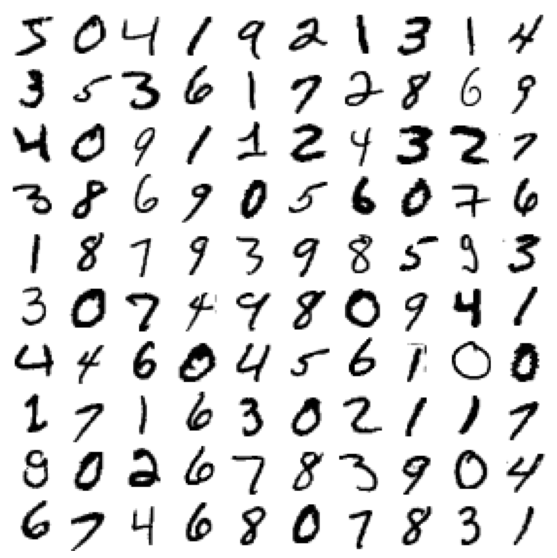

In [11]:
plt.figure(figsize=(10,10))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
y[0]

5

In [13]:
# split the data set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clg = SGDClassifier(random_state=42)
sgd_clg.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clg.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clg, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

## Performance measure

### Measuring accuracy using cross val

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clg)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [19]:
## dump classifier --> classify every single image in the 'not-5' class

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clg = Never5Classifier()
cross_val_score(never_5_clg, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clg, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### precison and recall

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1,1] / (cm[1,1] + cm[0,1])

0.8370879772350012

In [26]:
# recall score 
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
#recall score using confusion matrix array
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1,1] / (cm[1,1] + cm[1,0])

0.6511713705958311

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Trade off

In [29]:
y_scores = sgd_clg.decision_function([some_digit])
y_scores

array([2164.22030239])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [32]:
y_scores = cross_val_predict(sgd_clg, X_train, y_train_5, cv=3,
                            method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

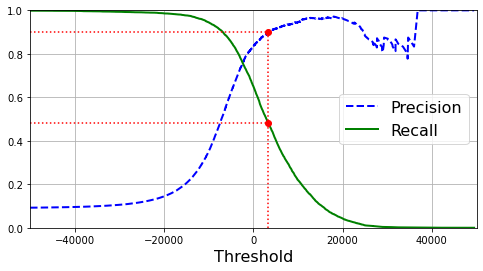

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
  
#creating a plot    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  
    
plt.show()

In [35]:
(y_train_pred == (y_scores > 0)).all()

True

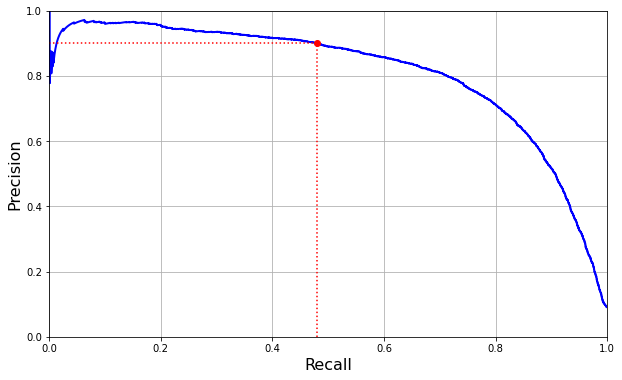

In [36]:
# plot precision/recall graph
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    

plt.figure(figsize=(10,6))
plot_precision_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., .9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, .9], "r:")
plt.plot([recall_90_precision], [0.9], "ro:")
plt.show()

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [38]:
threshold_90_precision

3370.0194991439594

In [39]:
y_train_90_pred = (y_scores >= threshold_90_precision)

In [40]:
precision_score(y_train_5, y_train_90_pred)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_90_pred)

0.4799852425751706

## Roc Curve

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

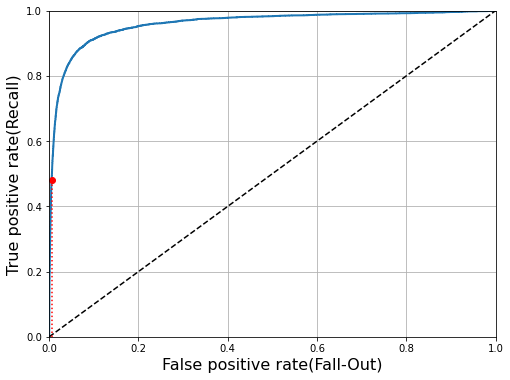

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1, 0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate(Fall-Out)', fontsize=16)
    plt.ylabel('True positive rate(Recall)', fontsize=16)
    plt.grid(True)
    
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [45]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [46]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

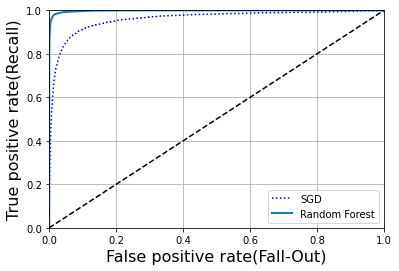

In [47]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass classification

In [51]:
sgd_clg.fit(X_train, y_train)
sgd_clg.predict([some_digit])

array([3], dtype=uint8)

In [52]:
some_digit_scores = sgd_clg.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
np.argmax(some_digit_scores)

3

In [54]:
sgd_clg.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
sgd_clg.classes_[3]

3

In [56]:
# one vs one classi
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
ovo_digit_scores = ovo_clf.decision_function([some_digit])
ovo_digit_scores

array([[2.66666696, 3.66666714, 5.33333258, 8.33333319, 0.6666669 ,
        9.33333315, 0.66666684, 2.66666841, 5.33333214, 6.33333275]])

In [58]:
np.argmax(ovo_digit_scores)

5

In [59]:
ovo_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
ovo_clf.classes_[5]

5

In [61]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.91545, 0.9131 , 0.92045])

#### Multiclass with svm

In [63]:
# direct using svm

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [65]:
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [66]:
np.argmax(some_digit_scores)

5

In [67]:
svm_clf.classes_[5]

5

In [68]:
# using svm with 'oneVsRestClassifier'
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])


array([5], dtype=uint8)

In [69]:
len(ovr_clf.estimators_)

10

## Error analysis

In [71]:
cross_val_score(sgd_clg, X_train, y_train,cv=3, scoring='accuracy' )

array([0.87365, 0.85835, 0.8689 ])

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clg, X_train_scaled, y_train,cv=3, scoring='accuracy' )

array([0.8983, 0.891 , 0.9018])

In [80]:
y_train_pred = cross_val_predict(sgd_clg, X_train_scaled, y_train,cv=3)

In [81]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

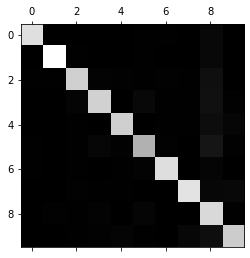

In [82]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [86]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum

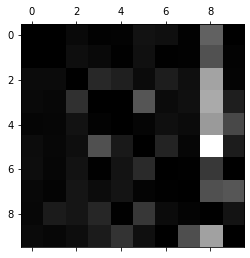

In [87]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

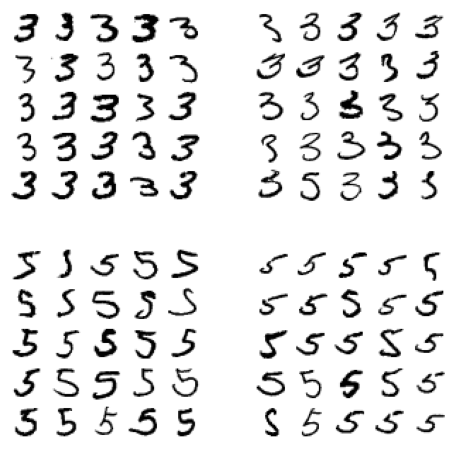

In [110]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [111]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [112]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [116]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

## Multioutput classification 

In [126]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

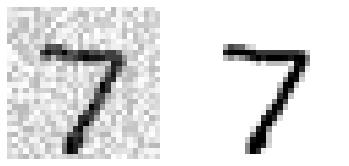

In [124]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

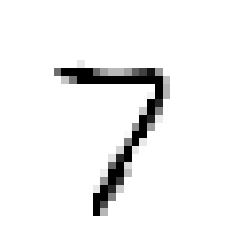

In [129]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)